In [1]:
import tensorflow as tf

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", tf.keras.__version__)
print("Tensorflow: ", tf.__version__)



Python:  3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas:  0.25.1
numpy:  1.17.2
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.21.3
Keras:  2.2.4-tf
Tensorflow:  2.0.0-rc1


In [20]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.set(rc={'axes.facecolor':'lightgray', 'figure.facecolor':'lightgray'})
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [3]:
#Loading data
filePath = './data/creditcardanomalydetection.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()



284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [6]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(inputArray)

decoded = tf.keras.layers.Dense(input_dim, activation='softmax')(encoded)

autoencoder = tf.keras.Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 12)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [26]:
#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray =  tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu',
               activity_regularizer=tf.keras.regularizers.l1(10e-5))(inputArray)

decoded = tf.keras.layers.Dense(input_dim, activation='softmax')(encoded)

autoencoder =  tf.keras.Model(inputArray, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                360       
_________________________________________________________________
dense_3 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [27]:
#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = tf.keras.Input(shape=(input_dim,))
encoded =  tf.keras.layers.Dense(encoding_dim, activation='relu')(inputArray)
encoded =  tf.keras.layers.Dense(8, activation='relu')(encoded)
encoded =  tf.keras.layers.Dense(4, activation='relu')(encoded)

decoded =  tf.keras.layers.Dense(8, activation='relu')(encoded)
decoded =  tf.keras.layers.Dense(encoding_dim, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(input_dim, activation='softmax')(decoded)

autoencoder = tf.keras.Model(inputArray, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_9 (Dense)              (None, 29)                493 

In [28]:
autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [29]:
from os.path import expanduser
home = expanduser("~")
home

'C:\\Users\\sridh'

In [30]:
batch_size = 32
epochs = 10

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='{0}\logs\{1}'.format(home, logfilename))])


Train on 16320 samples, validate on 4080 samples
Epoch 1/10
16320/16320 [==============================] - 3s 204us/sample - loss: 1.5129 - mae: 0.6851 - accuracy: 0.0928 - val_loss: 2.1212 - val_mae: 0.6905 - val_accuracy: 0.2534
Epoch 2/10
16320/16320 [==============================] - 3s 193us/sample - loss: 1.4604 - mae: 0.6644 - accuracy: 0.3833 - val_loss: 2.0758 - val_mae: 0.6768 - val_accuracy: 0.4493
Epoch 3/10
16320/16320 [==============================] - 3s 180us/sample - loss: 1.4358 - mae: 0.6586 - accuracy: 0.5205 - val_loss: 2.0624 - val_mae: 0.6731 - val_accuracy: 0.5375
Epoch 4/10
16320/16320 [==============================] - 3s 175us/sample - loss: 1.4284 - mae: 0.6564 - accuracy: 0.5650 - val_loss: 2.0607 - val_mae: 0.6722 - val_accuracy: 0.5605
Epoch 5/10
16320/16320 [==============================] - 3s 163us/sample - loss: 1.4264 - mae: 0.6559 - accuracy: 0.5756 - val_loss: 2.0586 - val_mae: 0.6718 - val_accuracy: 0.5679
Epoch 6/10
16320/16320 [=================

In [31]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 84us/sample - loss: 2.0540 - mae: 0.6709 - accuracy: 0.5900
Test loss: 2.053965605240242
Test accuracy: 0.67088103


In [32]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



In [33]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.59      0.56      0.57        93

    accuracy                           0.98      4080
   macro avg       0.79      0.78      0.78      4080
weighted avg       0.98      0.98      0.98      4080



In [34]:
roc_auc_score(y_test, y_label)

0.7750552197868881

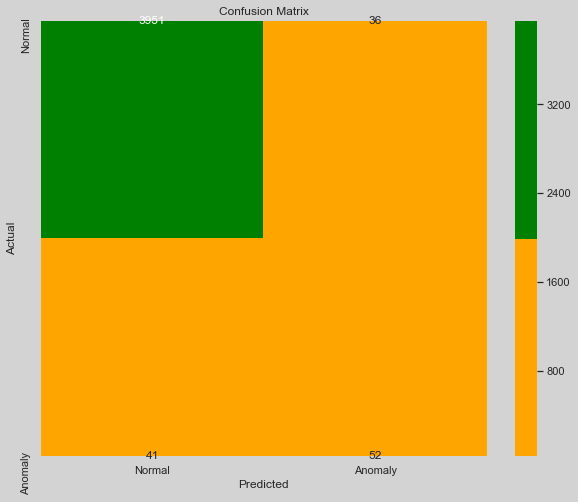

In [35]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

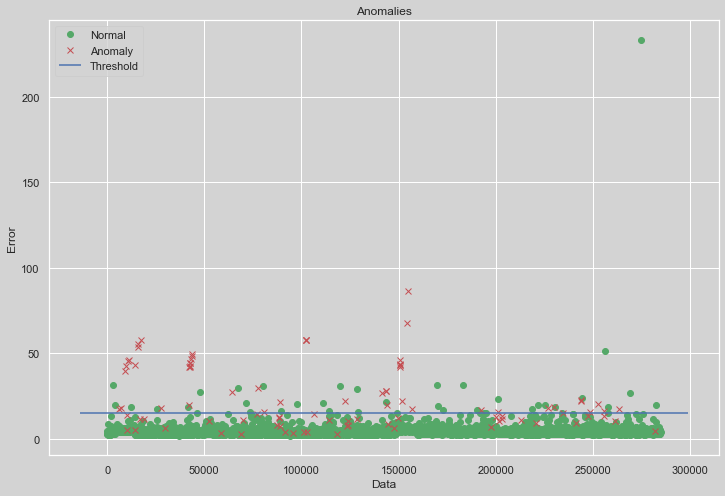

In [36]:
viz.draw_anomaly(y_test, error, threshold)